In [1]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import SwinModel
from transformers.models.swin.modeling_swin import SwinLayer

import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

import torch
import torch.nn as nn
from transformers.models.swin.modeling_swin import SwinPatchEmbeddings, SwinPatchMerging, SwinLayer
from transformers import SwinConfig
from typing import Tuple, Optional
# --- Cài đặt tham số cố định ---
IMG_SIZE = 320 
NUM_EPOCHS = 200
LEARNING_RATE = 1e-4
SEED = 42
BATCH_SIZE = 2
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- Đường dẫn dữ liệu (Thay đổi nếu cần) ---
train_img_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\train\image'
train_mask_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\train\label'
val_img_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\val\image'
val_mask_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\val\label'

# --- Thu thập đường dẫn tệp ảnh và mask ---
train_img_paths = sorted([os.path.join(train_img_dir, f) for f in os.listdir(train_img_dir)])
train_mask_paths = sorted([os.path.join(train_mask_dir, f) for f in os.listdir(train_mask_dir)])
val_img_paths = sorted([os.path.join(val_img_dir, f) for f in os.listdir(val_img_dir)])
val_mask_paths = sorted([os.path.join(val_mask_dir, f) for f in os.listdir(val_mask_dir)])


c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Using device: cuda


In [2]:
class CrackDetectionDataset(Dataset):
    def __init__(self, image_filenames, mask_filenames, transform=None):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_filenames[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(self.mask_filenames[idx], cv2.IMREAD_GRAYSCALE)
        mask = np.where(mask > 0, 255.0, 0.0).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
        
        mask = mask / 255.0
        mask = mask.unsqueeze(0)

        return img, mask

train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [3]:
class PatchExpanding(nn.Module):
    def __init__(self, input_resolution: Tuple[int, int], dim: int, return_vector: bool = True):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.expand = nn.Linear(dim, 2 * dim, bias=False)
        self.norm = nn.LayerNorm(dim // 2)
        self.return_vector = return_vector

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        H, W = self.input_resolution
        x = x.view(-1, H, W, self.dim)
        x = self.expand(x)
        B, H, W, C = x.shape
        x = x.view(B, H, W, 2, 2, C // 4)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H * 2, W * 2, C // 4)
        x = self.norm(x)
        if self.return_vector:
            x = x.view(B, -1, C // 4)
        return x


class FinalPatchExpanding(nn.Module):
    def __init__(self, dim: int, scale_factor: int = 4):
        super().__init__()
        self.scale_factor = scale_factor
        self.output_dim = dim // scale_factor

        expand_dim = self.output_dim * (scale_factor**2)
        self.expand = nn.Linear(dim, expand_dim, bias=False)

        self.norm = nn.LayerNorm(self.output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, L, _ = x.shape
        H = W = int(np.sqrt(L))
        x_expanded = self.expand(x)

        x_reshaped = x_expanded.view(B, H, W, self.scale_factor, self.scale_factor, self.output_dim)

        x_permuted = x_reshaped.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H * self.scale_factor, W * self.scale_factor, self.output_dim)

        x_normed = self.norm(x_permuted)

        output = x_normed.view(B, -1, self.output_dim)
        
        return output


class SkipAttention(nn.Module):
    def __init__(self, query_dim: int, context_dim: Optional[int] = None, num_heads: int = 8, dim_head: int = 64):
        super().__init__()
        if context_dim is None:
            context_dim = query_dim
        
        self.attn = nn.MultiheadAttention(embed_dim=query_dim, num_heads=num_heads, 
                                          kdim=context_dim, vdim=context_dim, 
                                          batch_first=True)
        self.norm = nn.LayerNorm(query_dim)

    def forward(self, query: torch.Tensor, context: torch.Tensor) -> torch.Tensor:
        attn_output, _ = self.attn(query=query, key=context, value=context)
        return self.norm(query + attn_output)


class ResidualSwinBlock(nn.Module):
    def __init__(self, config: SwinConfig, dim: int, input_resolution: Tuple[int, int], num_layers: int, num_heads: int):
        super().__init__()
        self.layers = nn.ModuleList([
            SwinLayer(
                config=config, 
                dim=dim, 
                input_resolution=input_resolution, 
                num_heads=num_heads, 
                shift_size=0 if (i % 2 == 0) else config.window_size // 2
            ) for i in range(num_layers)
        ])
        
    def forward(self, x: torch.Tensor, input_resolution: Tuple[int, int]) -> torch.Tensor:
        residual = x
        for layer in self.layers:
            x = layer(x, input_resolution)[0]
        return x + residual


class iSwinUnet(nn.Module):
    def __init__(self, num_classes: int = 1, img_size: int = 320, pretrained: bool = True):
        super().__init__()
        self.num_classes = num_classes
        self.img_size = img_size
        
        # --- Config ---
        config = SwinConfig(image_size=img_size, patch_size=4, window_size=7)
        self.config = config
        self.encoder_channels = [config.embed_dim * (2**i) for i in range(len(config.depths))]

        # --- Encoder ---
        self.patch_embed = SwinPatchEmbeddings(config)
        self.pos_drop = nn.Dropout(p=config.hidden_dropout_prob)

        self.encoder_stage1 = ResidualSwinBlock(config, self.encoder_channels[0], (img_size//4, img_size//4), config.depths[0], config.num_heads[0])
        self.merge1 = SwinPatchMerging(input_resolution=(img_size//4, img_size//4), dim=self.encoder_channels[0])
        
        self.encoder_stage2 = ResidualSwinBlock(config, self.encoder_channels[1], (img_size//8, img_size//8), config.depths[1], config.num_heads[1])
        self.merge2 = SwinPatchMerging(input_resolution=(img_size//8, img_size//8), dim=self.encoder_channels[1])

        self.encoder_stage3 = ResidualSwinBlock(config, self.encoder_channels[2], (img_size//16, img_size//16), config.depths[2], config.num_heads[2])
        self.merge3 = SwinPatchMerging(input_resolution=(img_size//16, img_size//16), dim=self.encoder_channels[2])
        
        self.bottleneck = ResidualSwinBlock(config, self.encoder_channels[3], (img_size//32, img_size//32), config.depths[3], config.num_heads[3])

        self.decoder_expand3 = PatchExpanding(input_resolution=(img_size//32, img_size//32), dim=self.encoder_channels[3])
        self.skip_attn3 = SkipAttention(query_dim=self.encoder_channels[2], context_dim=self.encoder_channels[2], num_heads=config.num_heads[2])
        self.decoder_stage3 = ResidualSwinBlock(config, self.encoder_channels[2], (img_size//16, img_size//16), config.depths[2], config.num_heads[2])

        self.decoder_expand2 = PatchExpanding(input_resolution=(img_size//16, img_size//16), dim=self.encoder_channels[2])
        self.skip_attn2 = SkipAttention(query_dim=self.encoder_channels[1], context_dim=self.encoder_channels[1], num_heads=config.num_heads[1])
        self.decoder_stage2 = ResidualSwinBlock(config, self.encoder_channels[1], (img_size//8, img_size//8), config.depths[1], config.num_heads[1])

        self.decoder_expand1 = PatchExpanding(input_resolution=(img_size//8, img_size//8), dim=self.encoder_channels[1])
        self.skip_attn1 = SkipAttention(query_dim=self.encoder_channels[0], context_dim=self.encoder_channels[0], num_heads=config.num_heads[0])
        self.decoder_stage1 = ResidualSwinBlock(config, self.encoder_channels[0], (img_size//4, img_size//4), config.depths[0], config.num_heads[0])

        self.final_expand = FinalPatchExpanding(dim=self.encoder_channels[0], scale_factor=4)
        self.final_conv = nn.Conv2d(self.final_expand.output_dim, num_classes, kernel_size=1)

        if pretrained:
            self.load_pretrained_weights()

    def load_pretrained_weights(self):
            print("Loading pretrained weights for Swin-Tiny encoder...")
            try:
                swin_original = SwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
                original_state_dict = swin_original.state_dict()

                model_state_dict = self.state_dict()

                prefix_mapping = {
                    'embeddings.patch_embeddings': 'patch_embed',
                    'encoder.layers.0.downsample': 'merge1',
                    'encoder.layers.1.downsample': 'merge2',
                    'encoder.layers.2.downsample': 'merge3',
                }

                stage_mapping = {
                    'encoder.layers.0': 'encoder_stage1',
                    'encoder.layers.1': 'encoder_stage2',
                    'encoder.layers.2': 'encoder_stage3',
                    'encoder.layers.3': 'bottleneck',
                }

                loaded_count = 0
                
                orig_pos_embed_key = 'embeddings.absolute_position_embedding'
                if orig_pos_embed_key in original_state_dict:
                    orig_pos_embed = original_state_dict[orig_pos_embed_key]
                    target_pos_embed = model_state_dict[orig_pos_embed_key]
                    if orig_pos_embed.shape != target_pos_embed.shape:
                        print(f"Interpolating absolute position embedding due to size mismatch...")
                        orig_pos_embed_spatial = orig_pos_embed[0, 1:, :].permute(1, 0)

                        H_orig = W_orig = int((orig_pos_embed.shape[1] - 1) ** 0.5)
                        orig_pos_embed_spatial = orig_pos_embed_spatial.view(1, -1, H_orig, W_orig)
                        H_target = W_target = int((target_pos_embed.shape[1] - 1) ** 0.5)
                        interp_pos_embed = nn.functional.interpolate(
                            orig_pos_embed_spatial, size=(H_target, W_target), mode='bicubic', align_corners=False
                        )
                        interp_pos_embed = interp_pos_embed.view(1, -1, H_target * W_target).permute(0, 2, 1)
                        # Thêm lại token [CLS]
                        final_pos_embed = torch.cat((orig_pos_embed[0, 0:1, :], interp_pos_embed[0]), dim=0).unsqueeze(0)
                        model_state_dict[orig_pos_embed_key] = final_pos_embed
                        loaded_count += 1
                    del original_state_dict[orig_pos_embed_key]

                for key_orig, value in original_state_dict.items():
                    new_key = None

                    if 'pooler' in key_orig:
                        continue

                    for old_prefix, new_prefix in prefix_mapping.items():
                        if key_orig.startswith(old_prefix):
                            new_key = key_orig.replace(old_prefix, new_prefix)
                            break

                    if new_key is None:
                        for old_stage_prefix, new_stage_prefix in stage_mapping.items():
                            if key_orig.startswith(old_stage_prefix):
                                remainder = key_orig[len(old_stage_prefix):]
                                if remainder.startswith('.blocks'):
                                    remainder = remainder.replace('.blocks', '', 1)
                                    new_key = f"{new_stage_prefix}.layers{remainder}"
                                break

                    if new_key is None:
                        if key_orig.startswith('embeddings.norm'):
                            new_key = key_orig.replace('embeddings.norm', 'patch_embed.norm')
                        elif key_orig.startswith('encoder.norm'):
                            continue

                    if new_key and new_key in model_state_dict and model_state_dict[new_key].shape == value.shape:
                        model_state_dict[new_key] = value
                        loaded_count += 1
                    else:
                        pass

                self.load_state_dict(model_state_dict, strict=False)

                expected_keys = len([k for k in swin_original.state_dict().keys() if 'pooler' not in k and 'encoder.norm' not in k])
                print(f"✅ Successfully loaded {loaded_count}/{expected_keys} tensors from pretrained Swin-Tiny.")
                print("   (Any unloaded tensors are expected to be from the decoder and final layers).")

            except Exception as e:
                print(f"❌ ERROR: Could not load pretrained weights. Error: {e}. Training from scratch.")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        s1_skip = self.patch_embed(x)[0]
        s1_skip = self.pos_drop(s1_skip)
        
        s1_out = self.encoder_stage1(s1_skip, (self.img_size//4, self.img_size//4))
        s2_in = self.merge1(s1_out, (self.img_size//4, self.img_size//4))
        
        s2_out = self.encoder_stage2(s2_in, (self.img_size//8, self.img_size//8))
        s3_in = self.merge2(s2_out, (self.img_size//8, self.img_size//8))

        s3_out = self.encoder_stage3(s3_in, (self.img_size//16, self.img_size//16))
        b_in = self.merge3(s3_out, (self.img_size//16, self.img_size//16))
        
        b_out = self.bottleneck(b_in, (self.img_size//32, self.img_size//32))

        d3_in = self.decoder_expand3(b_out)
        d3_in = self.skip_attn3(query=d3_in, context=s3_out)
        d3_out = self.decoder_stage3(d3_in, (self.img_size//16, self.img_size//16))

        d2_in = self.decoder_expand2(d3_out)
        d2_in = self.skip_attn2(query=d2_in, context=s2_out)
        d2_out = self.decoder_stage2(d2_in, (self.img_size//8, self.img_size//8))

        d1_in = self.decoder_expand1(d2_out)
        d1_in = self.skip_attn1(query=d1_in, context=s1_out)
        d1_out = self.decoder_stage1(d1_in, (self.img_size//4, self.img_size//4))
        
        final_features = self.final_expand(d1_out)
        
        B, L, C = final_features.shape
        H = W = int(np.sqrt(L))
        final_features = final_features.permute(0, 2, 1).contiguous().view(B, C, H, W)
        
        output = self.final_conv(final_features)
        
        return output

In [4]:

class IoULoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(IoULoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Mô hình trả về logits, cần đưa qua sigmoid để có xác suất trong khoảng (0, 1)
        inputs = torch.sigmoid(inputs)
        
        # Làm phẳng inputs và targets để tính toán dễ dàng
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        # Tính toán intersection (phần giao) và union (phần hợp)
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection
        
        # Tính IoU, thêm smooth để tránh chia cho 0
        iou = (intersection + self.smooth) / (union + self.smooth)
        
        # Loss là 1 - IoU, vì mục tiêu của chúng ta là tối đa hóa IoU
        return 1 - iou

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        Args:
            inputs (torch.Tensor): Raw logits from the model of shape (B, 1, H, W).
            targets (torch.Tensor): Ground truth masks of shape (B, 1, H, W).
        
        Returns:
            torch.Tensor: The calculated focal loss.
        """
        # Use BCEWithLogitsLoss for numerical stability. It combines a Sigmoid layer 
        # and the BCELoss in one single class.
        # We set reduction='none' to get the loss for each pixel individually.
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        
        # To get the probabilities, we apply sigmoid to the logits.
        p = torch.sigmoid(inputs)
        
        # Calculate pt, which is p for the positive class and 1-p for the negative class.
        # pt = p if targets is 1, and 1-p if targets is 0.
        pt = p * targets + (1 - p) * (1 - targets)
        
        # Calculate the focal loss modulating factor: (1 - pt)^gamma
        focal_factor = (1 - pt).pow(self.gamma)
        
        # Calculate the alpha weighting factor
        # alpha_t = alpha for the positive class, and 1-alpha for the negative class.
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        
        # The final focal loss formula
        loss = alpha_t * focal_factor * BCE_loss
        
        # Apply the specified reduction
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

def calculate_metrics(predicted_masks, true_masks, smooth=1e-6):
    predicted_masks = predicted_masks.view(-1)
    true_masks = true_masks.view(-1)
    
    intersection = (predicted_masks * true_masks).sum()
    union = (predicted_masks + true_masks).sum() - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    dice = (2. * intersection + smooth) / (predicted_masks.sum() + true_masks.sum() + smooth)
    
    return iou.item(), dice.item()

In [5]:
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs, callbacks_config, start_epoch=0, best_val_iou=0.0, history=None):
    best_iou = best_val_iou
    patience_counter = 0
    checkpoint_path = callbacks_config.get('checkpoint_path', 'model_best.pth')
    
    if history is None:
        history = {'train_loss': [], 'val_loss': [], 'train_iou': [], 'val_iou': [], 'lr': []}

    for epoch in range(start_epoch, num_epochs):
        model.train()
        train_loss, train_iou = 0.0, 0.0
        
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for images, masks in loop:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted_masks = (torch.sigmoid(outputs) > 0.5).float()
            
            batch_iou, _ = calculate_metrics(predicted_masks, masks)
            train_iou += batch_iou
            
            loop.set_postfix(loss=loss.item(), iou=batch_iou)

        history['train_loss'].append(train_loss / len(train_loader))
        history['train_iou'].append(train_iou / len(train_loader))
        
        model.eval()
        val_loss, val_iou = 0.0, 0.0
        
        loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for images, masks in loop:
                images, masks = images.to(DEVICE), masks.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                val_loss += loss.item()
                predicted_masks = (torch.sigmoid(outputs) > 0.5).float()
                
                batch_iou, _ = calculate_metrics(predicted_masks, masks)
                val_iou += batch_iou

        avg_val_loss = val_loss / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)
        
        history['val_loss'].append(avg_val_loss)
        history['val_iou'].append(avg_val_iou)
        
        scheduler.step(avg_val_loss) # Sử dụng validation loss cho scheduler
        current_lr = optimizer.param_groups[0]['lr']
        history['lr'].append(current_lr)
        
        print(f"Epoch {epoch+1} Summary:")
        print(f"  Train -> Loss: {history['train_loss'][-1]:.4f}, IoU: {history['train_iou'][-1]:.4f}")
        print(f"  Val   -> Loss: {avg_val_loss:.4f}, IoU: {avg_val_iou:.4f}")
        print(f"  LR: {current_lr:.8f}")

        if avg_val_iou > best_iou:
            best_iou = avg_val_iou
            patience_counter = 0
            print(f"🚀 New best validation IoU: {best_iou:.4f}. Saving model...")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_iou': best_iou,
                'scheduler_state_dict': scheduler.state_dict(),
                'history': history
            }, checkpoint_path)
        else:
            patience_counter += 1
            print(f"Validation IoU did not improve. Patience: {patience_counter}/{callbacks_config['patience']}")
            if patience_counter >= callbacks_config['patience']:
                print("Early stopping!")
                break
    return history

# --- Hàm vẽ biểu đồ (Đã chỉnh sửa chỉ dùng IoU) ---
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Sửa đổi: Tạo một hàng 3 cột cho 3 biểu đồ
    fig, axs = plt.subplots(1, 3, figsize=(22, 6))

    # Biểu đồ 1: Loss
    axs[0].plot(epochs, history['train_loss'], 'o-', label='Train Loss')
    axs[0].plot(epochs, history['val_loss'], 'o-', label='Validation Loss')
    axs[0].set_title('Training and Validation Loss')
    axs[0].set(xlabel='Epoch', ylabel='Loss')
    axs[0].legend()

    # Biểu đồ 2: IoU
    axs[1].plot(epochs, history['train_iou'], 'o-', label='Train IoU')
    axs[1].plot(epochs, history['val_iou'], 'o-', label='Validation IoU')
    axs[1].set_title('Training and Validation IoU')
    axs[1].set(xlabel='Epoch', ylabel='IoU')
    axs[1].legend()

    axs[2].plot(epochs, history['lr'], 'o-', label='Learning Rate', color='purple')
    axs[2].set_title('Learning Rate per Epoch')
    axs[2].set(xlabel='Epoch', ylabel='Learning Rate')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

def evaluate_model(model, data_loader, threshold=0.5):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, masks in tqdm(data_loader, desc="Evaluating"):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            outputs = model(images)
            preds = torch.sigmoid(outputs)

            preds = (preds > threshold).float()

            all_preds.append(preds.view(-1).cpu().numpy())
            all_targets.append(masks.view(-1).cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    iou = jaccard_score(all_targets, all_preds, zero_division=0)

    print(f"\n--- Evaluation Metrics ---")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"IoU:       {iou:.4f}")


Initializing iSwinUnet model (paper version)...
Loading pretrained weights for Swin-Tiny encoder...
✅ Successfully loaded 227/231 tensors from pretrained Swin-Tiny.
   (Any unloaded tensors are expected to be from the decoder and final layers).
!!! USING BCEWithLogitsLoss with pos_weight=30 !!!
Model has 41,657,773 trainable parameters.
✅ Found initial weights at: iswin_unet_paper.pth
   Loading model weights for fine-tuning. Optimizer and scheduler are reset.


C:\Users\Admin\AppData\Local\Temp\ipykernel_21960\1723505417.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(INITIAL_WEIGHTS_PATH, map_location=

   Starting new training run from Epoch 0.

--- Starting Training ---


Epoch 1/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.71it/s]


Epoch 1 Summary:
  Train -> Loss: 0.0027, IoU: 0.5830
  Val   -> Loss: 0.0058, IoU: 0.4075
  LR: 0.00010000
🚀 New best validation IoU: 0.4075. Saving model...


Epoch 2/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.88it/s]


Epoch 2 Summary:
  Train -> Loss: 0.0028, IoU: 0.5767
  Val   -> Loss: 0.0061, IoU: 0.4620
  LR: 0.00010000
🚀 New best validation IoU: 0.4620. Saving model...


Epoch 3/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.63it/s]


Epoch 3 Summary:
  Train -> Loss: 0.0032, IoU: 0.5595
  Val   -> Loss: 0.0053, IoU: 0.4768
  LR: 0.00010000
🚀 New best validation IoU: 0.4768. Saving model...


Epoch 4/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.54it/s]


Epoch 4 Summary:
  Train -> Loss: 0.0028, IoU: 0.5798
  Val   -> Loss: 0.0056, IoU: 0.4829
  LR: 0.00010000
🚀 New best validation IoU: 0.4829. Saving model...


Epoch 5/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.67it/s]


Epoch 5 Summary:
  Train -> Loss: 0.0027, IoU: 0.5862
  Val   -> Loss: 0.0057, IoU: 0.4606
  LR: 0.00010000
Validation IoU did not improve. Patience: 1/20


Epoch 6/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.22it/s]


Epoch 6 Summary:
  Train -> Loss: 0.0027, IoU: 0.5862
  Val   -> Loss: 0.0061, IoU: 0.4807
  LR: 0.00010000
Validation IoU did not improve. Patience: 2/20


Epoch 7/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.20it/s]


Epoch 7 Summary:
  Train -> Loss: 0.0028, IoU: 0.5782
  Val   -> Loss: 0.0055, IoU: 0.4709
  LR: 0.00010000
Validation IoU did not improve. Patience: 3/20


Epoch 8/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.06it/s]


Epoch 8 Summary:
  Train -> Loss: 0.0027, IoU: 0.5846
  Val   -> Loss: 0.0056, IoU: 0.4611
  LR: 0.00010000
Validation IoU did not improve. Patience: 4/20


Epoch 9/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 11.89it/s]


Epoch 9 Summary:
  Train -> Loss: 0.0030, IoU: 0.5673
  Val   -> Loss: 0.0050, IoU: 0.4547
  LR: 0.00010000
Validation IoU did not improve. Patience: 5/20


Epoch 10/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.26it/s]


Epoch 10 Summary:
  Train -> Loss: 0.0028, IoU: 0.5762
  Val   -> Loss: 0.0055, IoU: 0.4685
  LR: 0.00010000
Validation IoU did not improve. Patience: 6/20


Epoch 11/200 [Val]: 100%|██████████| 200/200 [00:17<00:00, 11.27it/s]


Epoch 11 Summary:
  Train -> Loss: 0.0026, IoU: 0.5912
  Val   -> Loss: 0.0056, IoU: 0.4809
  LR: 0.00010000
Validation IoU did not improve. Patience: 7/20


Epoch 12/200 [Val]: 100%|██████████| 200/200 [00:17<00:00, 11.71it/s]


Epoch 12 Summary:
  Train -> Loss: 0.0026, IoU: 0.5936
  Val   -> Loss: 0.0056, IoU: 0.4678
  LR: 0.00010000
Validation IoU did not improve. Patience: 8/20


Epoch 13/200 [Val]: 100%|██████████| 200/200 [00:17<00:00, 11.17it/s]


Epoch 13 Summary:
  Train -> Loss: 0.0027, IoU: 0.5848
  Val   -> Loss: 0.0050, IoU: 0.4679
  LR: 0.00010000
Validation IoU did not improve. Patience: 9/20


Epoch 14/200 [Val]: 100%|██████████| 200/200 [00:17<00:00, 11.24it/s]


Epoch 14 Summary:
  Train -> Loss: 0.0027, IoU: 0.5902
  Val   -> Loss: 0.0059, IoU: 0.4763
  LR: 0.00010000
Validation IoU did not improve. Patience: 10/20


Epoch 15/200 [Val]: 100%|██████████| 200/200 [00:17<00:00, 11.30it/s]


Epoch 15 Summary:
  Train -> Loss: 0.0027, IoU: 0.5878
  Val   -> Loss: 0.0055, IoU: 0.4904
  LR: 0.00005000
🚀 New best validation IoU: 0.4904. Saving model...


Epoch 16/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.00it/s]


Epoch 16 Summary:
  Train -> Loss: 0.0025, IoU: 0.6047
  Val   -> Loss: 0.0055, IoU: 0.4915
  LR: 0.00005000
🚀 New best validation IoU: 0.4915. Saving model...


Epoch 17/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.02it/s]


Epoch 17 Summary:
  Train -> Loss: 0.0024, IoU: 0.6147
  Val   -> Loss: 0.0061, IoU: 0.4924
  LR: 0.00005000
🚀 New best validation IoU: 0.4924. Saving model...


Epoch 18/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 11.98it/s]


Epoch 18 Summary:
  Train -> Loss: 0.0023, IoU: 0.6218
  Val   -> Loss: 0.0059, IoU: 0.4949
  LR: 0.00005000
🚀 New best validation IoU: 0.4949. Saving model...


Epoch 19/200 [Val]: 100%|██████████| 200/200 [00:17<00:00, 11.60it/s]


Epoch 19 Summary:
  Train -> Loss: 0.0023, IoU: 0.6170
  Val   -> Loss: 0.0062, IoU: 0.4943
  LR: 0.00005000
Validation IoU did not improve. Patience: 1/20


Epoch 20/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.41it/s]


Epoch 20 Summary:
  Train -> Loss: 0.0023, IoU: 0.6262
  Val   -> Loss: 0.0065, IoU: 0.4949
  LR: 0.00005000
🚀 New best validation IoU: 0.4949. Saving model...


Epoch 21/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.07it/s]


Epoch 21 Summary:
  Train -> Loss: 0.0022, IoU: 0.6230
  Val   -> Loss: 0.0063, IoU: 0.4950
  LR: 0.00002500
🚀 New best validation IoU: 0.4950. Saving model...


Epoch 22/200 [Val]: 100%|██████████| 200/200 [00:17<00:00, 11.74it/s]


Epoch 22 Summary:
  Train -> Loss: 0.0022, IoU: 0.6300
  Val   -> Loss: 0.0064, IoU: 0.4976
  LR: 0.00002500
🚀 New best validation IoU: 0.4976. Saving model...


Epoch 23/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.67it/s]


Epoch 23 Summary:
  Train -> Loss: 0.0021, IoU: 0.6307
  Val   -> Loss: 0.0070, IoU: 0.5002
  LR: 0.00002500
🚀 New best validation IoU: 0.5002. Saving model...


Epoch 24/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.95it/s]


Epoch 24 Summary:
  Train -> Loss: 0.0021, IoU: 0.6386
  Val   -> Loss: 0.0067, IoU: 0.4990
  LR: 0.00002500
Validation IoU did not improve. Patience: 1/20


Epoch 25/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.39it/s]


Epoch 25 Summary:
  Train -> Loss: 0.0021, IoU: 0.6388
  Val   -> Loss: 0.0068, IoU: 0.5012
  LR: 0.00002500
🚀 New best validation IoU: 0.5012. Saving model...


Epoch 26/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.57it/s]


Epoch 26 Summary:
  Train -> Loss: 0.0021, IoU: 0.6458
  Val   -> Loss: 0.0071, IoU: 0.5024
  LR: 0.00002500
🚀 New best validation IoU: 0.5024. Saving model...


Epoch 27/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.85it/s]


Epoch 27 Summary:
  Train -> Loss: 0.0020, IoU: 0.6410
  Val   -> Loss: 0.0065, IoU: 0.5009
  LR: 0.00001250
Validation IoU did not improve. Patience: 1/20


Epoch 28/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.45it/s]


Epoch 28 Summary:
  Train -> Loss: 0.0020, IoU: 0.6505
  Val   -> Loss: 0.0069, IoU: 0.4998
  LR: 0.00001250
Validation IoU did not improve. Patience: 2/20


Epoch 29/200 [Val]: 100%|██████████| 200/200 [00:23<00:00,  8.34it/s]


Epoch 29 Summary:
  Train -> Loss: 0.0020, IoU: 0.6487
  Val   -> Loss: 0.0071, IoU: 0.4976
  LR: 0.00001250
Validation IoU did not improve. Patience: 3/20


Epoch 30/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.74it/s]


Epoch 30 Summary:
  Train -> Loss: 0.0020, IoU: 0.6485
  Val   -> Loss: 0.0072, IoU: 0.5029
  LR: 0.00001250
🚀 New best validation IoU: 0.5029. Saving model...


Epoch 31/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.35it/s]


Epoch 31 Summary:
  Train -> Loss: 0.0019, IoU: 0.6538
  Val   -> Loss: 0.0074, IoU: 0.5022
  LR: 0.00001250
Validation IoU did not improve. Patience: 1/20


Epoch 32/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.01it/s]


Epoch 32 Summary:
  Train -> Loss: 0.0019, IoU: 0.6545
  Val   -> Loss: 0.0073, IoU: 0.5027
  LR: 0.00001250
Validation IoU did not improve. Patience: 2/20


Epoch 33/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.05it/s]


Epoch 33 Summary:
  Train -> Loss: 0.0019, IoU: 0.6544
  Val   -> Loss: 0.0073, IoU: 0.5035
  LR: 0.00000625
🚀 New best validation IoU: 0.5035. Saving model...


Epoch 34/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.04it/s]


Epoch 34 Summary:
  Train -> Loss: 0.0019, IoU: 0.6614
  Val   -> Loss: 0.0075, IoU: 0.5018
  LR: 0.00000625
Validation IoU did not improve. Patience: 1/20


Epoch 35/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.76it/s]


Epoch 35 Summary:
  Train -> Loss: 0.0019, IoU: 0.6552
  Val   -> Loss: 0.0076, IoU: 0.5046
  LR: 0.00000625
🚀 New best validation IoU: 0.5046. Saving model...


Epoch 36/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.55it/s]


Epoch 36 Summary:
  Train -> Loss: 0.0019, IoU: 0.6558
  Val   -> Loss: 0.0076, IoU: 0.5024
  LR: 0.00000625
Validation IoU did not improve. Patience: 1/20


Epoch 37/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.84it/s]


Epoch 37 Summary:
  Train -> Loss: 0.0019, IoU: 0.6579
  Val   -> Loss: 0.0074, IoU: 0.5044
  LR: 0.00000625
Validation IoU did not improve. Patience: 2/20


Epoch 38/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.93it/s]


Epoch 38 Summary:
  Train -> Loss: 0.0019, IoU: 0.6649
  Val   -> Loss: 0.0074, IoU: 0.5025
  LR: 0.00000625
Validation IoU did not improve. Patience: 3/20


Epoch 39/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.17it/s]


Epoch 39 Summary:
  Train -> Loss: 0.0019, IoU: 0.6586
  Val   -> Loss: 0.0074, IoU: 0.5035
  LR: 0.00000313
Validation IoU did not improve. Patience: 4/20


Epoch 40/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.91it/s]


Epoch 40 Summary:
  Train -> Loss: 0.0019, IoU: 0.6604
  Val   -> Loss: 0.0077, IoU: 0.5038
  LR: 0.00000313
Validation IoU did not improve. Patience: 5/20


Epoch 41/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.61it/s]


Epoch 41 Summary:
  Train -> Loss: 0.0019, IoU: 0.6656
  Val   -> Loss: 0.0076, IoU: 0.5024
  LR: 0.00000313
Validation IoU did not improve. Patience: 6/20


Epoch 42/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 11.97it/s]


Epoch 42 Summary:
  Train -> Loss: 0.0018, IoU: 0.6660
  Val   -> Loss: 0.0078, IoU: 0.5040
  LR: 0.00000313
Validation IoU did not improve. Patience: 7/20


Epoch 43/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 11.97it/s]


Epoch 43 Summary:
  Train -> Loss: 0.0018, IoU: 0.6663
  Val   -> Loss: 0.0078, IoU: 0.5030
  LR: 0.00000313
Validation IoU did not improve. Patience: 8/20


Epoch 44/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.21it/s]


Epoch 44 Summary:
  Train -> Loss: 0.0018, IoU: 0.6626
  Val   -> Loss: 0.0079, IoU: 0.5033
  LR: 0.00000313
Validation IoU did not improve. Patience: 9/20


Epoch 45/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.62it/s]


Epoch 45 Summary:
  Train -> Loss: 0.0018, IoU: 0.6642
  Val   -> Loss: 0.0080, IoU: 0.5042
  LR: 0.00000156
Validation IoU did not improve. Patience: 10/20


Epoch 46/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.33it/s]


Epoch 46 Summary:
  Train -> Loss: 0.0018, IoU: 0.6621
  Val   -> Loss: 0.0080, IoU: 0.5038
  LR: 0.00000156
Validation IoU did not improve. Patience: 11/20


Epoch 47/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.34it/s]


Epoch 47 Summary:
  Train -> Loss: 0.0018, IoU: 0.6630
  Val   -> Loss: 0.0079, IoU: 0.5038
  LR: 0.00000156
Validation IoU did not improve. Patience: 12/20


Epoch 48/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.60it/s]


Epoch 48 Summary:
  Train -> Loss: 0.0018, IoU: 0.6682
  Val   -> Loss: 0.0081, IoU: 0.5037
  LR: 0.00000156
Validation IoU did not improve. Patience: 13/20


Epoch 49/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.49it/s]


Epoch 49 Summary:
  Train -> Loss: 0.0018, IoU: 0.6614
  Val   -> Loss: 0.0081, IoU: 0.5039
  LR: 0.00000156
Validation IoU did not improve. Patience: 14/20


Epoch 50/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.10it/s]


Epoch 50 Summary:
  Train -> Loss: 0.0018, IoU: 0.6630
  Val   -> Loss: 0.0081, IoU: 0.5040
  LR: 0.00000156
Validation IoU did not improve. Patience: 15/20


Epoch 51/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.00it/s]


Epoch 51 Summary:
  Train -> Loss: 0.0018, IoU: 0.6679
  Val   -> Loss: 0.0081, IoU: 0.5032
  LR: 0.00000078
Validation IoU did not improve. Patience: 16/20


Epoch 52/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.87it/s]


Epoch 52 Summary:
  Train -> Loss: 0.0018, IoU: 0.6668
  Val   -> Loss: 0.0081, IoU: 0.5034
  LR: 0.00000078
Validation IoU did not improve. Patience: 17/20


Epoch 53/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.68it/s]


Epoch 53 Summary:
  Train -> Loss: 0.0018, IoU: 0.6695
  Val   -> Loss: 0.0081, IoU: 0.5034
  LR: 0.00000078
Validation IoU did not improve. Patience: 18/20


Epoch 54/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.15it/s]


Epoch 54 Summary:
  Train -> Loss: 0.0018, IoU: 0.6680
  Val   -> Loss: 0.0081, IoU: 0.5038
  LR: 0.00000078
Validation IoU did not improve. Patience: 19/20


Epoch 55/200 [Val]: 100%|██████████| 200/200 [00:14<00:00, 13.59it/s]


Epoch 55 Summary:
  Train -> Loss: 0.0018, IoU: 0.6685
  Val   -> Loss: 0.0081, IoU: 0.5039
  LR: 0.00000078
Validation IoU did not improve. Patience: 20/20
Early stopping!

--- Training complete. ---
Plotting training history...


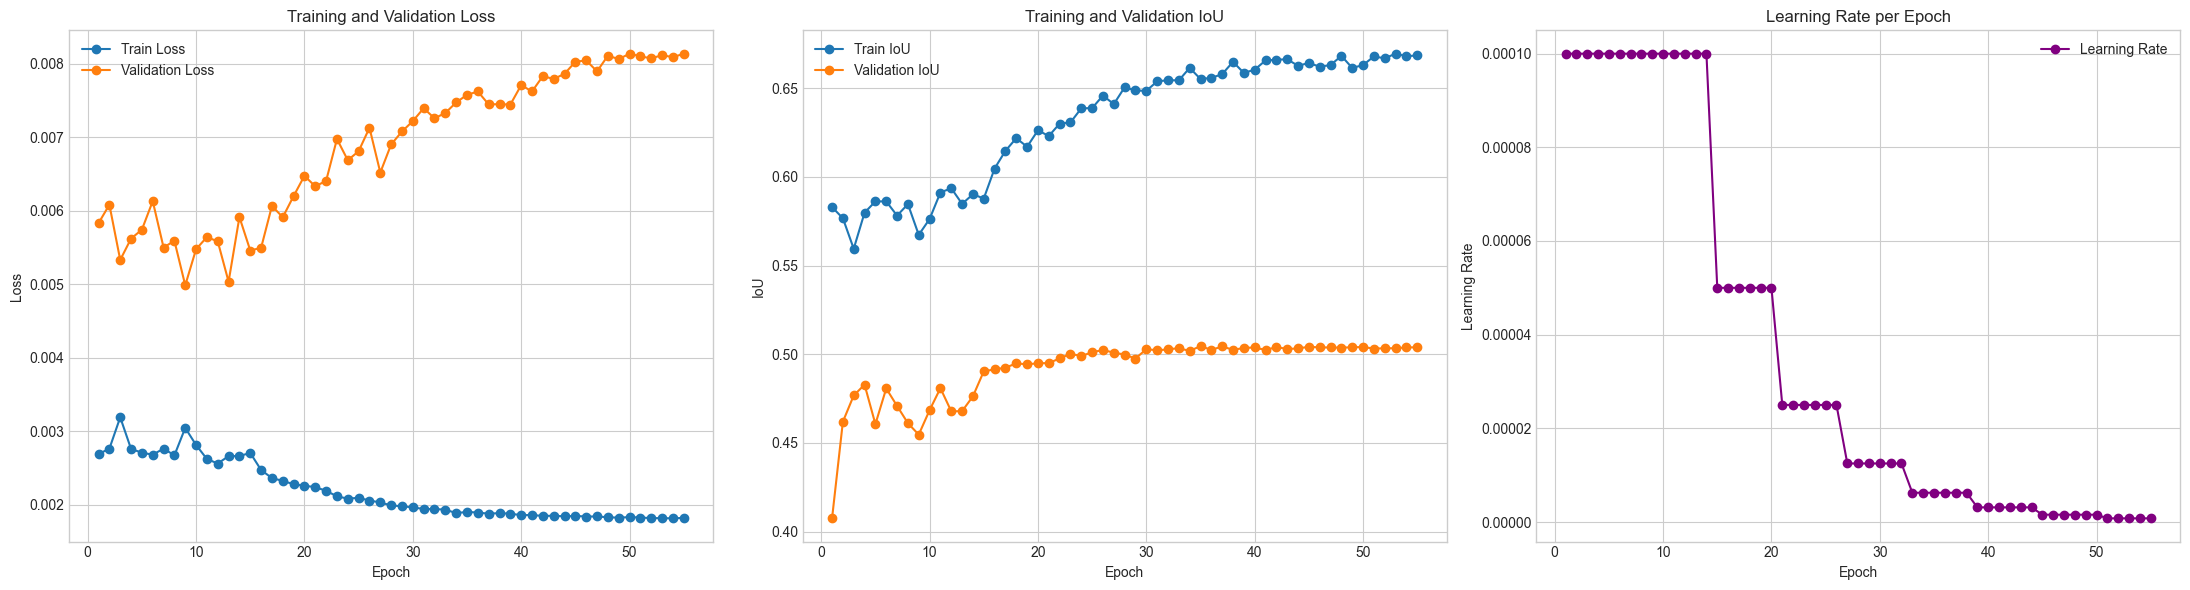


--- Evaluating the best model on the validation set ---


C:\Users\Admin\AppData\Local\Temp\ipykernel_21960\1723505417.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(NEW_CHECKPOINT_PATH)['mode


--- Evaluation Metrics ---
Precision: 0.6442
Recall:    0.8112
F1-score:  0.7181
IoU:       0.5602


In [7]:
if __name__ == '__main__':
    # --- Chuẩn bị dữ liệu ---
    train_img_paths = sorted([os.path.join(train_img_dir, f) for f in os.listdir(train_img_dir)])
    train_mask_paths = sorted([os.path.join(train_mask_dir, f) for f in os.listdir(train_mask_dir)])
    val_img_paths = sorted([os.path.join(val_img_dir, f) for f in os.listdir(val_img_dir)])
    val_mask_paths = sorted([os.path.join(val_mask_dir, f) for f in os.listdir(val_mask_dir)])

    train_transform = A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5), A.RandomRotate90(p=0.5),
        A.ColorJitter(p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

    val_transform = A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

    train_dataset = CrackDetectionDataset(train_img_paths, train_mask_paths, transform=train_transform)
    val_dataset = CrackDetectionDataset(val_img_paths, val_mask_paths, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

    # --- Khởi tạo Model, Optimizer, Loss ---
    print("Initializing iSwinUnet model (paper version)...")
    model = iSwinUnet(num_classes=1, img_size=IMG_SIZE, pretrained=True).to(DEVICE)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-7)
    
    pos_weight_value = 30
    criterion = FocalLoss(alpha=0.8, gamma=2)
    
    print("="*50)
    print(f"!!! USING BCEWithLogitsLoss with pos_weight={pos_weight_value} !!!")
    print(f"Model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters.")
    print("="*50)

    INITIAL_WEIGHTS_PATH = 'iswin_unet_paper.pth'

    NEW_CHECKPOINT_PATH = 'iswin_unet_paper_Focal.pth'
    
    callbacks_config = {'patience': 20, 'checkpoint_path': NEW_CHECKPOINT_PATH}
    start_epoch, best_val_iou, history = 0, 0.0, None

    if os.path.exists(NEW_CHECKPOINT_PATH):
        print(f"✅ Resuming training from existing checkpoint: {NEW_CHECKPOINT_PATH}")
        checkpoint = torch.load(NEW_CHECKPOINT_PATH, map_location=DEVICE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint.get('optimizer_state_dict'))
        scheduler.load_state_dict(checkpoint.get('scheduler_state_dict'))
        start_epoch = checkpoint.get('epoch', 0) + 1
        best_val_iou = checkpoint.get('best_val_iou', 0.0)
        history = checkpoint.get('history')
        print(f"   Resuming from Epoch {start_epoch}. Best Val IoU so far: {best_val_iou:.4f}")
    elif os.path.exists(INITIAL_WEIGHTS_PATH):
        print(f"✅ Found initial weights at: {INITIAL_WEIGHTS_PATH}")
        print("   Loading model weights for fine-tuning. Optimizer and scheduler are reset.")
        checkpoint = torch.load(INITIAL_WEIGHTS_PATH, map_location=DEVICE)
        # Chỉ tải trọng số mô hình, không tải optimizer, epoch,...
        model.load_state_dict(checkpoint['model_state_dict'])
        print("   Starting new training run from Epoch 0.")
    else:
        print(f"⚠️ No checkpoints found at '{NEW_CHECKPOINT_PATH}' or '{INITIAL_WEIGHTS_PATH}'.")
        print("   Loading default Swin-Tiny weights from Hugging Face for the encoder.")
        model.load_pretrained_weights()
        print("   Starting new training run from scratch (Epoch 0).")


    # --- Bắt đầu Huấn luyện ---
    print(f"\n--- Starting Training ---")
    training_history = train_model(
        model, train_loader, val_loader, optimizer, criterion, scheduler,
        num_epochs=NUM_EPOCHS, callbacks_config=callbacks_config,
        start_epoch=start_epoch, best_val_iou=best_val_iou, history=history
    )
    
    print("\n--- Training complete. ---")

    # --- Vẽ biểu đồ và Đánh giá ---
    if training_history and len(training_history['train_loss']) > 0:
        print("Plotting training history...")
        plot_training_history(training_history)
        
        # Đánh giá trên tập validation với mô hình tốt nhất đã lưu
        print("\n--- Evaluating the best model on the validation set ---")
        model.load_state_dict(torch.load(NEW_CHECKPOINT_PATH)['model_state_dict'])
        evaluate_model(model, val_loader, threshold=0.5)
    else:
        print("No training history available to plot.")

In [ ]:
thresholds = np.arange(0.3, 0.5, 0.05)
all_preds_raw = []
all_targets = []

model.eval()
with torch.no_grad():
    for images, masks in tqdm(val_loader, desc="Collecting predictions"):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        outputs = model(images)
        probs = torch.sigmoid(outputs)

        all_preds_raw.append(probs.view(-1).cpu().numpy())
        all_targets.append(masks.view(-1).cpu().numpy())

all_preds_raw = np.concatenate(all_preds_raw)
all_targets = np.concatenate(all_targets)

metrics = {'threshold': [], 'precision': [], 'recall': [], 'f1': [], 'iou': []}

for t in thresholds:
    preds_bin = (all_preds_raw > t).astype(np.uint8)

    precision = precision_score(all_targets, preds_bin, zero_division=0)
    recall = recall_score(all_targets, preds_bin, zero_division=0)
    f1 = f1_score(all_targets, preds_bin, zero_division=0)
    iou = jaccard_score(all_targets, preds_bin, zero_division=0)

    metrics['threshold'].append(t)
    metrics['precision'].append(precision)
    metrics['recall'].append(recall)
    metrics['f1'].append(f1)
    metrics['iou'].append(iou)

best_f1_idx = int(np.argmax(metrics['f1']))
best_iou_idx = int(np.argmax(metrics['iou']))

print("\n=== Threshold Tốt Nhất ===")
print(f"[F1]  Best at threshold = {metrics['threshold'][best_f1_idx]:.2f} | F1 = {metrics['f1'][best_f1_idx]:.4f}")
print(f"[IoU] Best at threshold = {metrics['threshold'][best_iou_idx]:.2f} | IoU = {metrics['iou'][best_iou_idx]:.4f}")


=== Threshold Tốt Nhất ===
[F1]  Best at threshold = 0.45 | F1 = 0.7042
[IoU] Best at threshold = 0.45 | IoU = 0.5435


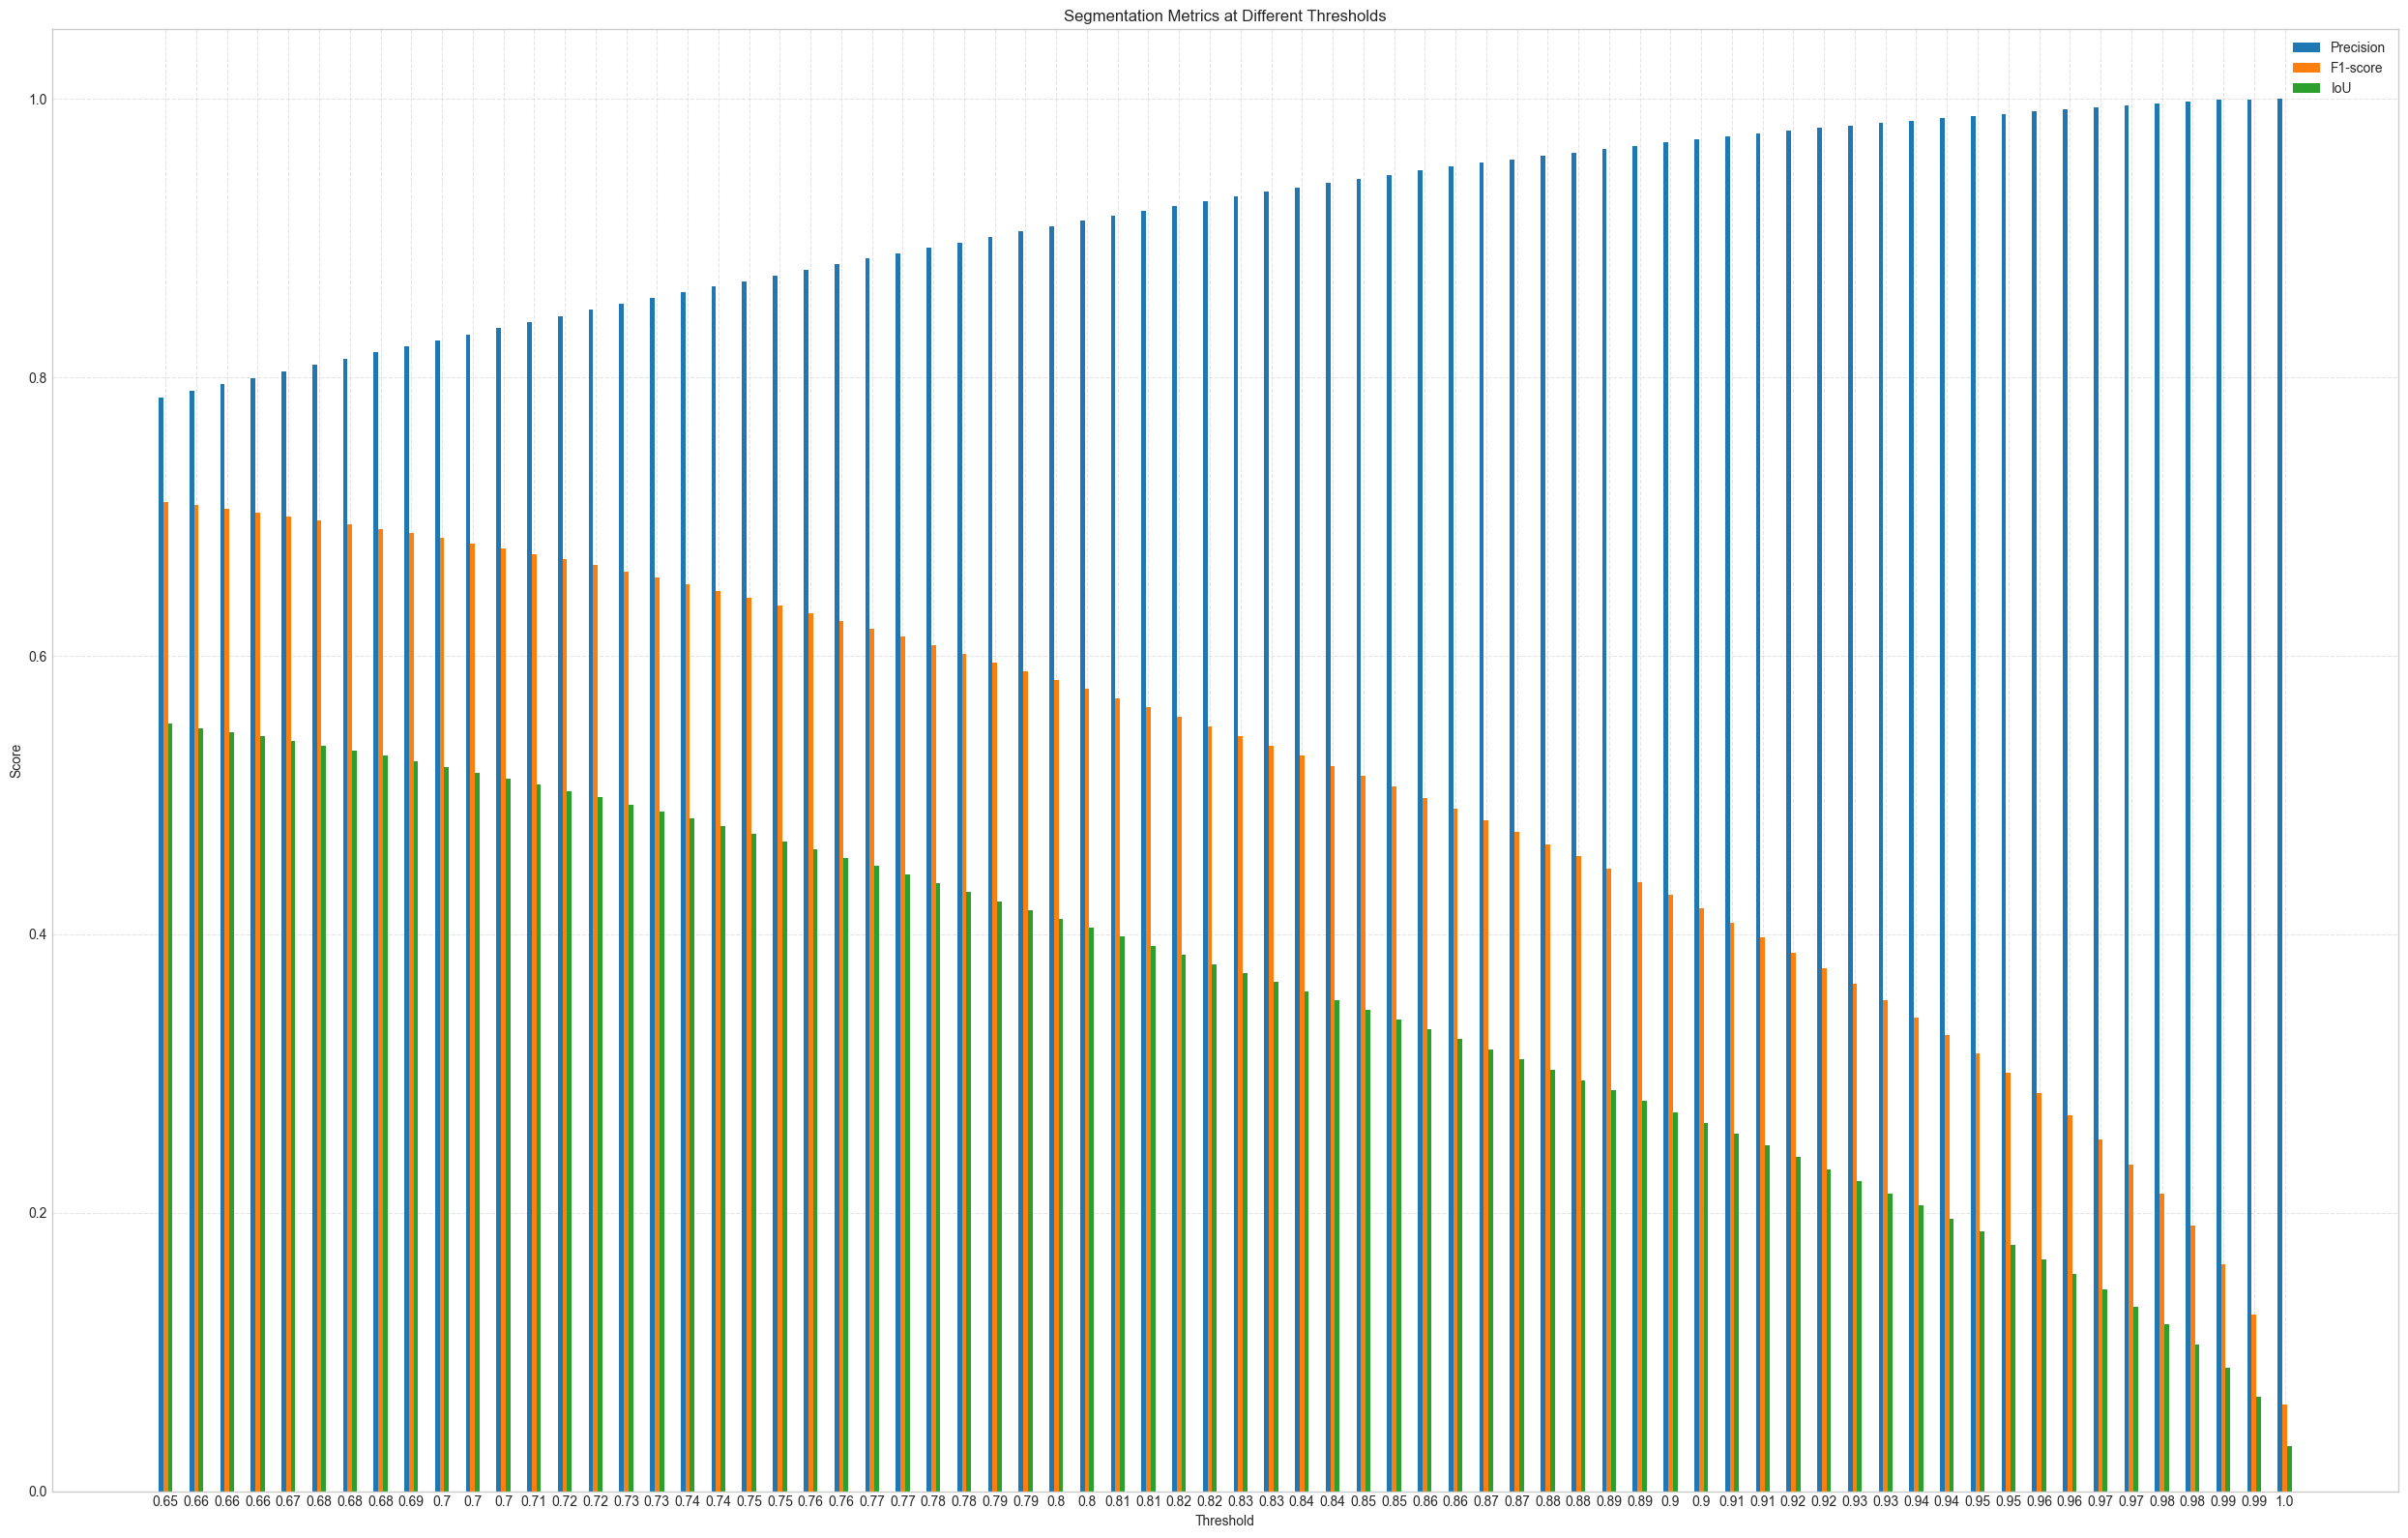

In [9]:
x = [round(t, 2) for t in metrics['threshold']]
x_idx = np.arange(len(x))
width = 0.15

plt.figure(figsize=(25, 16))
plt.bar(x_idx - width, metrics['precision'], width=width, label='Precision')
plt.bar(x_idx, metrics['f1'], width=width, label='F1-score')
plt.bar(x_idx + width, metrics['iou'], width=width, label='IoU')

plt.xticks(x_idx, x)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Segmentation Metrics at Different Thresholds')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()